In [1]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch as th
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
device = th.device('mps' if th.backends.mps.is_available else 'cpu')
import copy
from torchvision.datasets import ImageFolder
from torch.distributions.normal import Normal

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + th.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
    
class MinMax(object):
    def __init__(self, new_min = 0., new_max = 1.):
        self.new_min = new_min
        self.new_max = new_max
        
    def __call__(self, tensor):
        v_min = tensor.min()
        v_max = tensor.max()
        return(tensor - v_min)/(v_max - v_min)*(self.new_max - self.new_min) + self.new_min
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [189]:
transform=transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0.,0.5),
    MinMax()
])

In [190]:
MNIST_train_noise = torchvision.datasets.MNIST('./', download = True, train = True, transform=transform)
MNIST_test_noise = torchvision.datasets.MNIST('./', download = True, train = False, transform=transform)

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True,transform=transforms.ToTensor())
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False,transform=transforms.ToTensor())

train_DL_noise = th.utils.data.DataLoader(
    dataset = MNIST_train_noise, batch_size = 128,
    shuffle = False)

test_DL_noise = th.utils.data.DataLoader(
    dataset = MNIST_test_noise, batch_size = 128,
    shuffle = False)

train_DL = th.utils.data.DataLoader(
    dataset = MNIST_train, batch_size = 128,
    shuffle = False)

test_DL = th.utils.data.DataLoader(
    dataset = MNIST_test, batch_size = 128,
    shuffle = False)

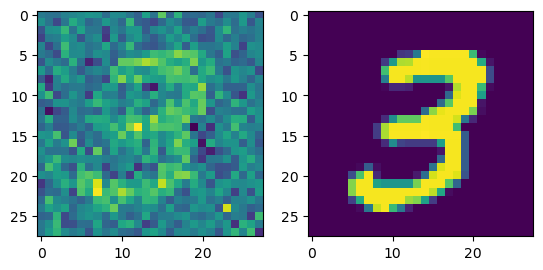

In [191]:
X_noise,y_noise = next(iter(train_DL_noise))
X,y = next(iter(train_DL))

plt.subplot(1,2,1)
plt.imshow(X_noise[7][0])

plt.subplot(1,2,2)
plt.imshow(X[7][0])

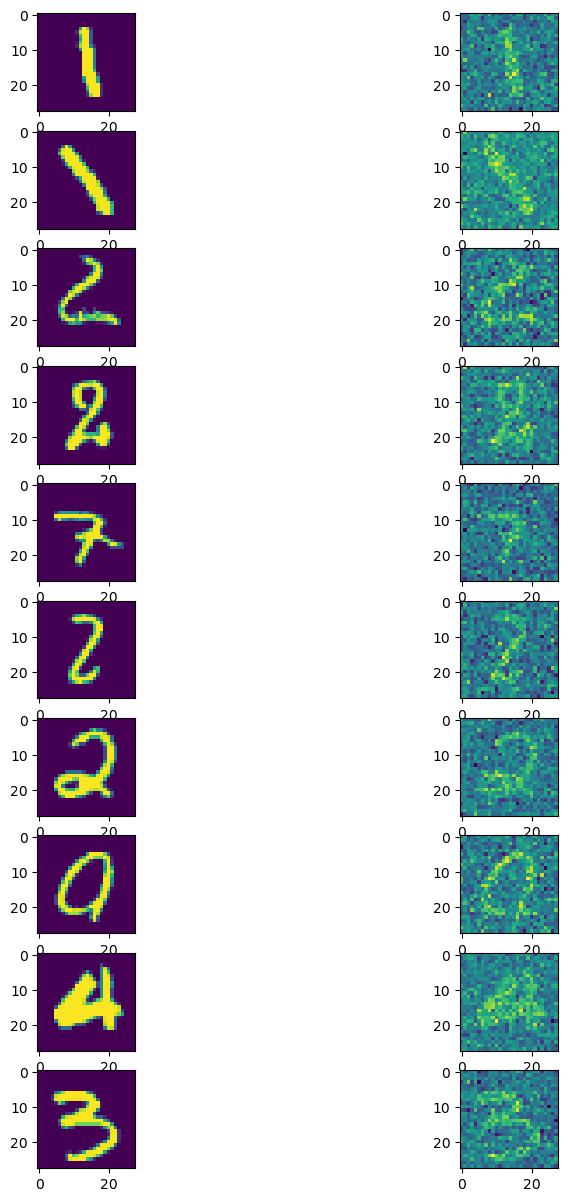

In [192]:
plt.figure(figsize = (10,15))
iter1 = iter(train_DL_noise)
iter2 = iter(train_DL)
for j in range(2):
    iter1 = iter(train_DL_noise)
    iter2 = iter(train_DL)
    for i in range(10):
        X_noise,y_noise = next(iter1)
        X,y = next(iter2)
        
        plt.subplot(10,2,(i+1)*2)
        plt.imshow(X_noise[6][0])

        plt.subplot(10,2,(i+1)*2-1)
        plt.imshow(X[6][0])

In [193]:
class Denoise(th.nn.Module):
    def __init__(self):
        super(Denoise, self).__init__()
        
        self.Conv1 = th.nn.Conv2d(1, 32, 3, padding=1, stride=1)
        self.F = th.nn.ReLU()
        self.Pool1 = th.nn.MaxPool2d(2,stride=2)
        
        self.Conv2 = th.nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.Pool2 = th.nn.MaxPool2d(2,stride=2)
        
        self.Conv3 = th.nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.Pool3 = th.nn.MaxPool2d(2,stride=2)
        
        self.Flat = th.nn.Flatten()
        self.FC1 = th.nn.Linear(1152,512)
        self.FC2 = th.nn.Linear(512,1152)
        
        self.Upconv1 = th.nn.ConvTranspose2d(128,64,3,stride = 2,padding=0)    
    
        self.Upconv2 = th.nn.ConvTranspose2d(64,32,3,stride = 2,padding=0)
        
        self.Upconv3 = th.nn.ConvTranspose2d(32,32,3,stride = 2,padding=1)
        
        self.Conv4 = th.nn.Conv2d(32, 1, 3, padding=1, stride=1)
        
        self.sygmoid = th.nn.Sigmoid()
        
        self.apply(self._init_weights)
        
        
    def forward(self, x):
        
        x = self.Conv1(x)
        x = self.F(x)
        x = self.Pool1(x)
        
        x = self.Conv2(x)
        x = self.F(x)
        x = self.Pool2(x)
        
        x = self.Conv3(x)
        x = self.F(x)
        x = self.Pool3(x)
            
        x = self.Flat(x)
        x = self.FC1(x)
        x = self.F(x)
        x = self.FC2(x)
        x = self.F(x)
        x = x.view(-1,128,3,3)
        
        x = self.Upconv1(x)
        x = self.F(x)
    
        x = self.Upconv2(x)
        x = self.F(x)
                
        x = self.Upconv3(x)
        x = self.F(x)
        
        x = self.Conv4(x)
        x = x[:,:,:28,:28]
        x = self.sygmoid(x)
        
        return x
    
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d) :
            module.weight.data.normal_(mean=0.0, std=0.1)
            if module.bias is not None:
                module.bias.data.zero_()

    

net = Denoise()


In [194]:
net = net.to(device)
cryterion = th.nn.MSELoss()
opt = th.optim.Adam(net.parameters(), lr = 0.001, betas=(0.9,0.99))

In [195]:
epochs = 10

minloss = 100
train_loss = []
test_loss = []

for epoch in range(epochs):
    iter1 = iter(train_DL_noise)
    iter2 = iter(train_DL)
    running_loss = 0

    for n_batch in range(len(train_DL)):
        opt.zero_grad()
        inp, _ = next(iter1)
        inp = inp.to(device)
        out = net.forward(inp)
        ans, _ = next(iter2)
        ans = ans.to(device)
        loss = cryterion(out,ans)
        loss.backward()
        opt.step()
        running_loss+=loss.item()
        

    train_loss.append(running_loss/(len(train_DL)))    
    running_loss = 0
    with th.no_grad():
        iter1_test = iter(test_DL_noise)
        iter2_test = iter(test_DL)

        for n_batch in range(len(test_DL)):
            inp, _ = next(iter1_test)
            inp = inp.to(device)
            pred = net.forward(inp)
            #print(pred.mean())
            ans, _ = next(iter2_test)
            ans = ans.to(device)
            loss = cryterion(pred,ans)
            running_loss += loss.item()

        test_loss.append(running_loss/len(test_DL))
        print(f'epoch {epoch},loss = {running_loss/len(test_DL)}')
        if running_loss/len(test_DL) < minloss:
            minloss = running_loss/len(test_DL)
            best_model = copy.deepcopy(net)


epoch 0,loss = 0.022482012551796587
epoch 1,loss = 0.01750972120775075
epoch 2,loss = 0.01556657521124882
epoch 3,loss = 0.01496967688627258
epoch 4,loss = 0.01358195659527673
epoch 5,loss = 0.01314487284685992
epoch 6,loss = 0.012639811639732953


KeyboardInterrupt: 

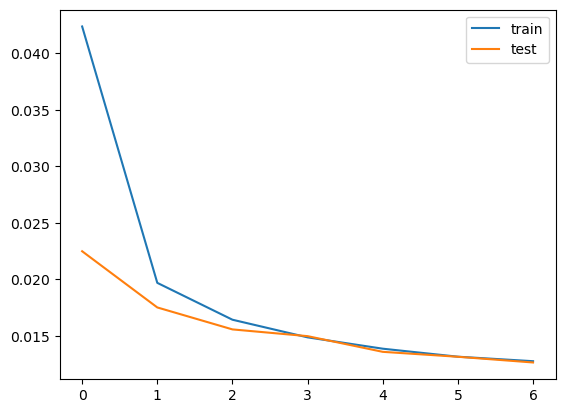

In [196]:
plt.plot(range(len(train_loss)),train_loss,label = 'train')
plt.plot(range(len(test_loss)),test_loss,label = 'test')

plt.legend()


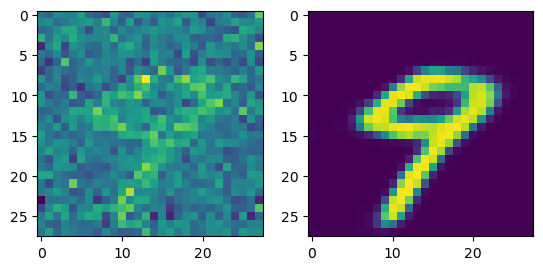

In [210]:
n = 9
X_noise,y_noise = next(iter(test_DL_noise))
X_noise = X_noise.to(device)
pred = best_model.forward(X_noise)
pred = pred.to(th.device('cpu')).detach().numpy()
plt.subplot(1,2,1)
plt.imshow(X_noise[n][0].to(th.device('cpu')))
plt.subplot(1,2,2)
plt.imshow(pred[n][0])

# Генератор изображений

5114 511
torch.Size([128, 3, 64, 64])


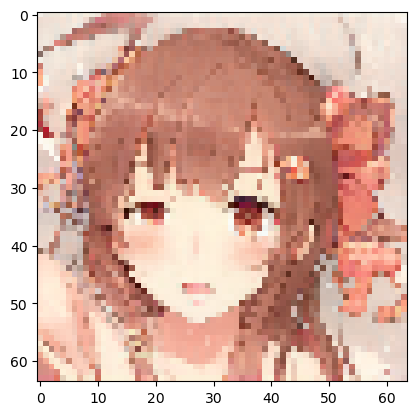

In [12]:
# path = '/Users/egormatolygin/Data/arcietexxture'
#path = '/Users/egormatolygin/Data/animals10/raw-img/cat'
path = '/Users/egormatolygin/Data/anime'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    MinMax()
])

folder = ImageFolder(path, transform=transform)

n = len(folder)  
n_test = int(0.1 * n)  
print(n,n_test)
test_set = th.utils.data.Subset(folder, range(n_test))  
train_set = th.utils.data.Subset(folder, range(n_test,n))  

buildings_train = th.utils.data.DataLoader(
    train_set, batch_size = 128,
    shuffle = True)

buildings_test = th.utils.data.DataLoader(
    test_set, batch_size = 128,
    shuffle = True)

X,y = next(iter(buildings_train))
print(X.size())
plt.imshow(X[0].permute(1,2,0))

In [13]:
embeding_size = 8

class ImgGen(th.nn.Module):
    def __init__(self):
        super(ImgGen, self).__init__()
        
        self.Conv1 = th.nn.Conv2d(3, 32, 3, padding=1, stride=2)
        self.BN1 = th.nn.BatchNorm2d(32)
        self.F = th.nn.LeakyReLU()
        self.Pool1 = th.nn.MaxPool2d(2,stride=2)
        
        self.Conv2 = th.nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.BN2 = th.nn.BatchNorm2d(64)
        self.Pool2 = th.nn.MaxPool2d(2,stride=2)
        
        self.Conv3 = th.nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.BN3 = th.nn.BatchNorm2d(128)
        self.Pool3 = th.nn.MaxPool2d(2,stride=2)
        
        self.Conv4 = th.nn.Conv2d(128, 256, 3, padding=1, stride=1)
        self.BN4 = th.nn.BatchNorm2d(256)
        self.Pool4 = th.nn.MaxPool2d(2,stride=2)
        
        self.Flat = th.nn.Flatten()
        self.FC_mean = th.nn.Linear(1024,embeding_size)

        self.FC_log_var = th.nn.Linear(1024,embeding_size)

        
        self.FC2 = th.nn.Linear(embeding_size,1024)
        self.BN6 = th.nn.BatchNorm1d(1024)        
        
        self.Upconv1 = th.nn.ConvTranspose2d(256,128,3,stride = 2,padding=0)
        self.BN7 = th.nn.BatchNorm2d(128)
        
    
        self.Upconv2 = th.nn.ConvTranspose2d(128,64,3,stride = 2,padding=1)
        self.BN8 = th.nn.BatchNorm2d(64)

        
        self.Upconv3 = th.nn.ConvTranspose2d(64,32,3,stride = 2,padding=1)
        self.BN9 = th.nn.BatchNorm2d(32)
        
        self.Upconv4 = th.nn.ConvTranspose2d(32,32,3,stride = 2,padding=1)
        self.BN10 = th.nn.BatchNorm2d(32)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.Conv5 = th.nn.Conv2d(32, 3, 3, padding=1, stride=1)
        
        self.sygmoid = th.nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.Conv1(x)
#         x = self.BN1(x)
        x = self.F(x)
        x = self.Pool1(x)
        
#         print(x.size())
        x = self.Conv2(x)
#         x = self.BN2(x)
        x = self.F(x)
        x = self.Pool2(x)
        
#         print(x.size())
        
        x = self.Conv3(x)
#         x = self.BN3(x)
        x = self.F(x)
        x = self.Pool3(x)
        
#         print(x.size())
        
        x = self.Conv4(x)
#         x = self.BN4(x)
        x = self.F(x)
        x = self.Pool4(x)
        
#         print(x.size())
            
        x = self.Flat(x)
        mean = self.FC_mean(x)
        var = self.FC_log_var(x)
        batch, dim = mean.shape
        epsilon = Normal(0, 1).sample((batch, dim)).to(device)
        x = mean + th.exp(0.5 * var) * epsilon

        x = self.FC2(x)
        x = x.view(-1,256,2,2)
        
#         print(x.size())
        
        x = self.Upconv1(x)
#         x = self.BN7(x)
        x = self.F(x)
        
#         print(x.size())
    
        x = self.Upconv2(x)
#         x = self.BN8(x)
        x = self.F(x)

        
#         print(x.size())
                
        x = self.Upconv3(x)
#         x = self.BN9(x)
        x = self.F(x)
        
#         print(x.size())
        
        x = self.Upconv4(x)
#         x = self.BN10(x)
        x = self.F(x)
        x = self.Upsample2(x)
        


#         print(x.size())
        
        x = self.Conv5(x)
        x = x[:,:,:64,:64]
        x = self.sygmoid(x)
        
        
#         print(x.size())
        
        return mean, var, x
    
                
    def gen(self,std):
        x = (th.rand((2,embeding_size))*std).to(device)
        
        x = self.FC2(x)
        x = x.view(-1,256,2,2)
        
#         print(x.size())
        
        x = self.Upconv1(x)
#         x = self.BN7(x)
        x = self.F(x)
        
#         print(x.size())
    
        x = self.Upconv2(x)
#         x = self.BN8(x)
        x = self.F(x)

        
#         print(x.size())
                
        x = self.Upconv3(x)
#         x = self.BN9(x)
        x = self.F(x)
        
#         print(x.size())
        
        x = self.Upconv4(x)
#         x = self.BN10(x)
        x = self.F(x)
        x = self.Upsample2(x)
        


#         print(x.size())
        
        x = self.Conv5(x)
        x = x[:,:,:64,:64]
        x = self.sygmoid(x)
        
        
#         print(x.size())
        
        return x

    
net = ImgGen()

In [14]:
net = net.to(device)

opt = th.optim.Adam(net.parameters(), lr = 0.001, betas=(0.9,0.99))

scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.1, patience=2, verbose=True
)


def vae_gaussian_kl_loss(mu, logvar):
    KLD = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return KLD.mean()

def reconstruction_loss(x_reconstructed, x):
    bce_loss = nn.BCELoss()
    return bce_loss(x_reconstructed, x)

def vae_loss(y_pred, y_true):
    mu, logvar, recon_x = y_pred
    recon_loss = reconstruction_loss(recon_x, y_true)
    kld_loss = vae_gaussian_kl_loss(mu, logvar)
    return 500 * recon_loss + kld_loss


In [15]:
epochs = 50

minloss = float('inf')
train_loss = []
test_loss = []

for epoch in range(epochs):
    
    running_loss = 0

    for X,y in buildings_train:
        opt.zero_grad()
        
        X = X.to(device)
        out = net.forward(X)
        loss = vae_loss(out,X)
        loss.backward()
        opt.step()
        running_loss+=loss.item()

    train_loss.append(running_loss/(len(buildings_train)))    
#     print(f'epoch {epoch},train_loss = {running_loss/(len(buildings_train))}')
    running_loss = 0
    with th.no_grad():
        
        for X,y in buildings_test:
            X = X.to(device)
            pred = net.forward(X)
            loss = vae_loss(pred,X)
            running_loss += loss.item()

        test_loss.append(running_loss/len(buildings_test))
        print(f'epoch {epoch},test_loss = {running_loss/len(buildings_test)}')
        if running_loss/len(buildings_test) < minloss:
            minloss = running_loss/len(buildings_test)
            best_model = copy.deepcopy(net)
    scheduler.step(running_loss/len(buildings_test))

epoch 0,test_loss = 308.6477737426758
epoch 1,test_loss = 287.88958740234375
epoch 2,test_loss = 279.92144775390625
epoch 3,test_loss = 271.88124084472656
epoch 4,test_loss = 265.4203643798828
epoch 5,test_loss = 262.75599670410156
epoch 6,test_loss = 259.95408630371094
epoch 7,test_loss = 258.4257278442383
epoch 8,test_loss = 257.60950088500977
epoch 9,test_loss = 257.3726348876953
epoch 10,test_loss = 257.05348205566406
epoch 11,test_loss = 256.8461380004883
epoch 12,test_loss = 255.97146606445312
epoch 13,test_loss = 256.2576599121094
epoch 14,test_loss = 256.16455841064453
epoch 15,test_loss = 255.54492568969727
epoch 16,test_loss = 255.6038475036621
epoch 17,test_loss = 255.29167556762695
epoch 18,test_loss = 255.23510360717773
epoch 19,test_loss = 254.71811294555664
epoch 20,test_loss = 254.84625244140625
epoch 21,test_loss = 254.33059310913086
epoch 22,test_loss = 254.41706085205078
epoch 23,test_loss = 254.29617309570312
epoch 24,test_loss = 254.6746368408203
epoch 25,test_loss

KeyboardInterrupt: 

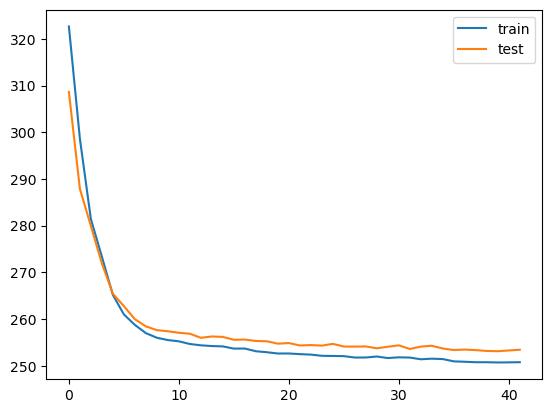

In [16]:
plt.plot(range(len(train_loss)),train_loss,label = 'train')
plt.plot(range(len(test_loss)),test_loss,label = 'test')

plt.legend()

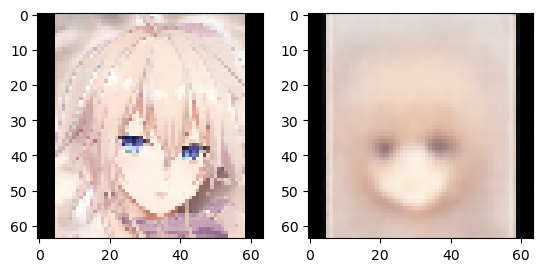

In [17]:
n = 21
X,y = next(iter(buildings_test))
X = X.to(device)
pred = best_model.forward(X)
pred = pred[2].to(th.device('cpu'))
plt.subplot(1,2,1)
plt.imshow(X[n].permute(1,2,0).to(th.device('cpu')))
plt.subplot(1,2,2)
plt.imshow(pred[n].permute(1,2,0).detach())

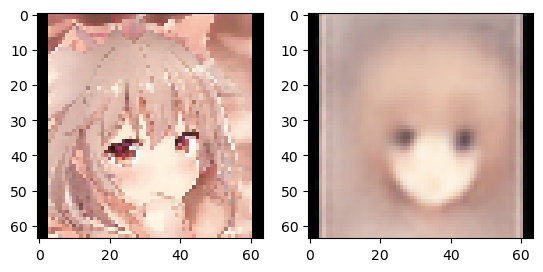

In [18]:
n = 21
X,y = next(iter(buildings_train))
X = X.to(device)
pred = best_model.forward(X)
pred = pred[2].to(th.device('cpu'))
plt.subplot(1,2,1)
plt.imshow(X[n].permute(1,2,0).to(th.device('cpu')))
plt.subplot(1,2,2)
plt.imshow(pred[n].permute(1,2,0).detach())

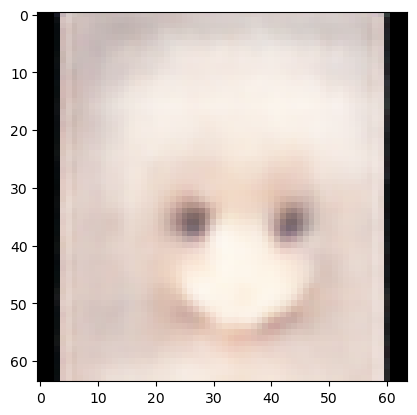

In [19]:
x = best_model.gen(3)
x = x.to(th.device('cpu'))
plt.imshow(x[0].permute(1,2,0).detach())

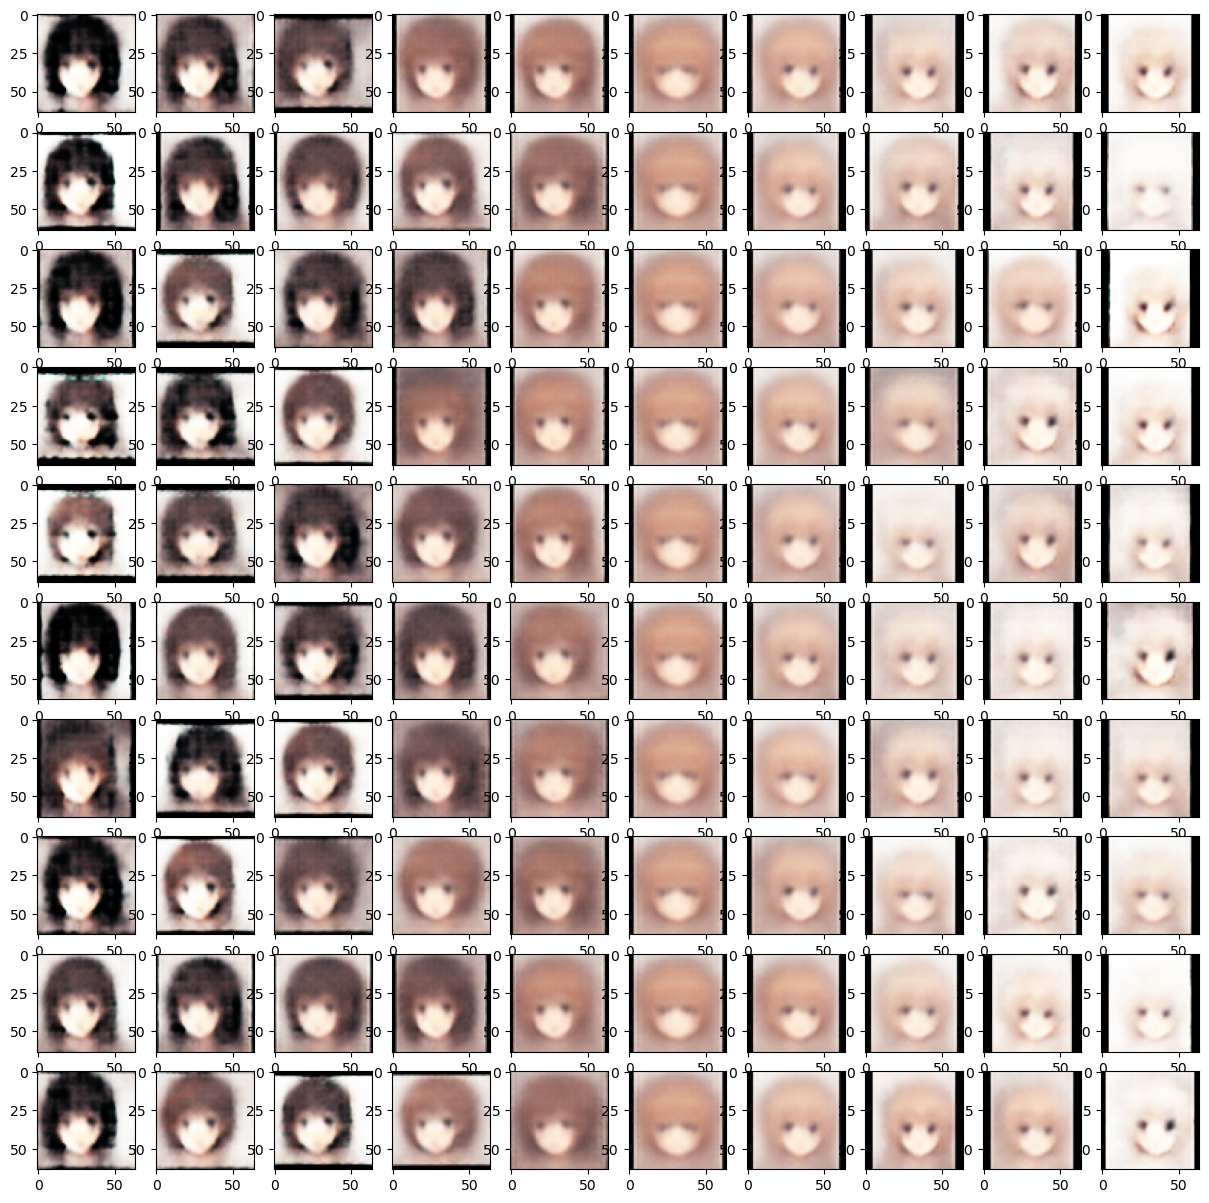

In [20]:
plt.figure(figsize=(15,15))

for j in range(10):
    for i in range(10):
        plt.subplot(10,10,i+1+(j)*10)
        x = best_model.gen(i-5)
        x = x.to(th.device('cpu'))
        plt.imshow(x[0].permute(1,2,0).detach())